In [1]:
%%writefile  Model_updated.py
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np 
import matplotlib.pyplot as plt


class RedemptionModel:

    def __init__(self, X, target_col):
        '''
        Args:
        X (pandas.DataFrame): Dataset of predictors, output from load_data()
        target_col (str): column name for target variable
        '''
        self._predictions = {}
        self.X = X
        self.target_col = target_col
        self.results = {} # dict of dicts with model results

    def score(self, truth, preds):
        # Score our predictions - modify this method as you like
        return MAPE(truth, preds)


    def run_models(self, n_splits=4, test_size=365):
        '''Run the models and store results for cross validated splits in
        self.results.
        '''
        # Time series split
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        cnt = 0 # keep track of splits
        for train, test in tscv.split(self.X):
            X_train = self.X.iloc[train]
            X_test = self.X.iloc[test]
            # Base model - please leave this here
            preds = self._base_model_(X_train, X_test)
            if 'Base' not in self.results:
                self.results['Base'] = {}
            self.results['Base'][cnt] = self.score(X_test[self.target_col],
                                preds)
            self.plot(preds, 'Base')
            # Other models...
            # self._my-new-model(train, test) << Add your model(s) here
            
            preds_modified=self._base_model_modified(X_train,X_test)
            if 'Base_modified' not in self.results:
                self.results['Base_modified'] = {}
            self.results['Base_modified'][cnt] = self.score(X_test[self.target_col],
                                preds_modified)
            self.plot(preds_modified, 'Base_modified')
            
            
            cnt += 1
      
    def _base_model_(self, train, test):
        '''
        Our base, too-simple model.
        Your model needs to take the training and test datasets (dataframes)
        and output a prediction based on the test data.

        Please leave this method as-is.

        '''
        res = sm.tsa.seasonal_decompose(train[self.target_col],
                                        period=365)
        res_clip = res.seasonal.apply(lambda x: max(0,x))
        res_clip.index = res_clip.index.dayofyear
        res_clip = res_clip.groupby(res_clip.index).mean()
        res_dict = res_clip.to_dict()
        return pd.Series(index = test.index, 
                         data = map(lambda x: res_dict[x], test.index.dayofyear))
        
       
            
            
            
            
    def _base_model_modified(self, train, test):
        '''
        Our base, too-simple model.
        Your model needs to take the training and test datasets (dataframes)
        and output a prediction based on the test data.

        Please leave this method as-is.

        '''
        #res = sm.tsa.seasonal_decompose(train[self.target_col],
        #                                period=365)
        #res_clip = res.seasonal.apply(lambda x: max(0,x))
        #res_clip.index = res_clip.index.dayofyear
        #res_clip = res_clip.groupby(res_clip.index).mean()
        #res_dict = res_clip.to_dict()
        #return pd.Series(index = test.index, 
        #                 data = map(lambda x: res_dict[x], test.index.dayofyear))
        
        #using holt winters to account for trend and seasonality
        series=train[self.target_col]
        hw=ExponentialSmoothing(
            series,
            trend='add',
            seasonal='add',
            seasonal_periods=365).fit(optimized=True)
        
        test_horizon=len(test)
        forecasted=hw.forecast(test_horizon)
        
        #remove the negative values
        forecasted=np.clip(forecasted.values,0,None)
        
        return pd.Series(forecasted,index=test.index)

    
    
    def plot(self, preds, label):
        # plot out the forecasts
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.scatter(self.X.index, self.X[self.target_col], s=0.4, color='grey',
            label='Observed')
        ax.plot(preds, label = label, color='red')
        plt.legend()

Writing Model_updated.py


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


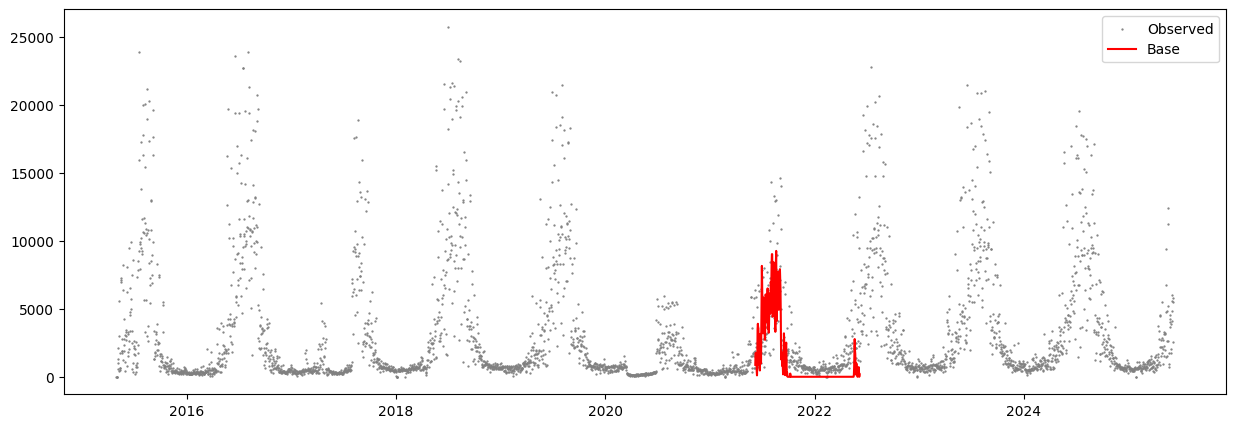

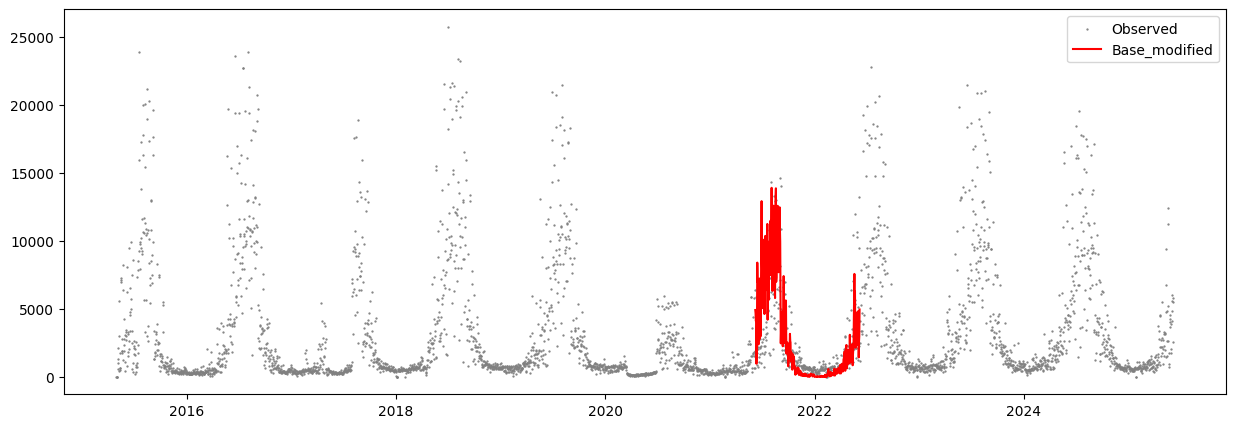

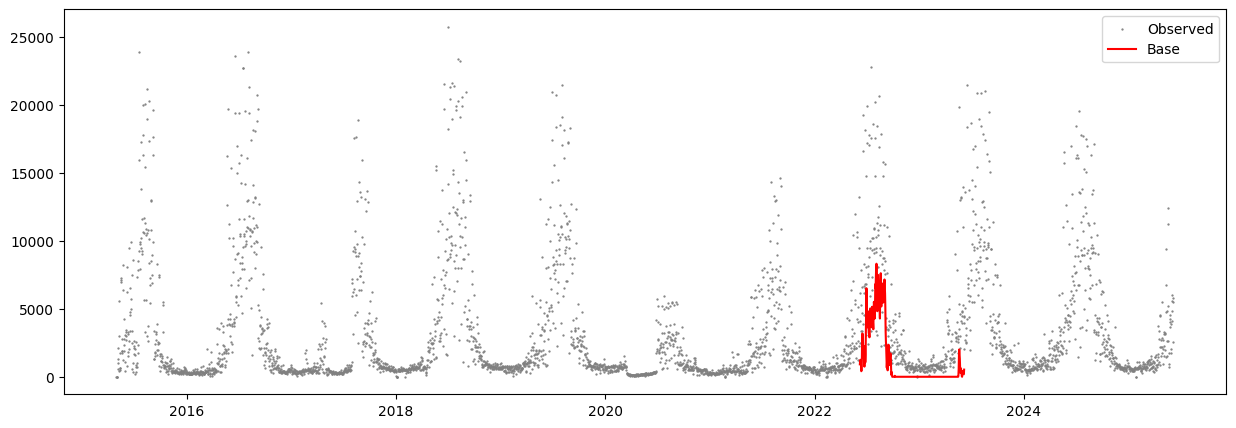

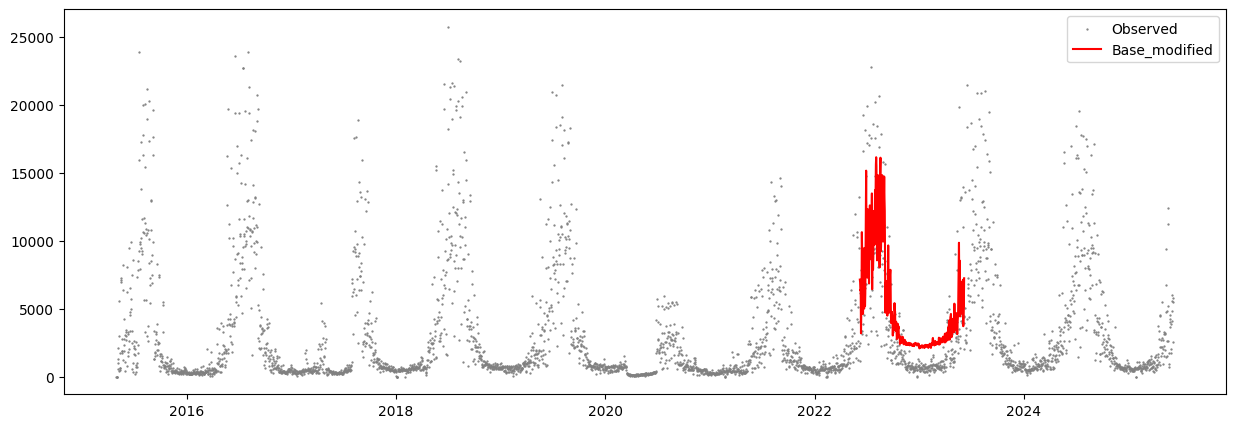

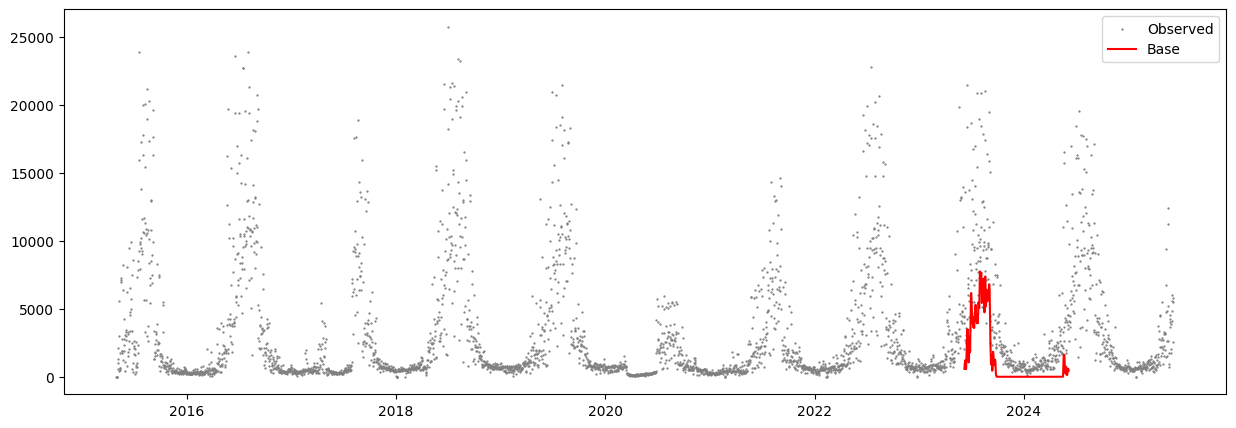

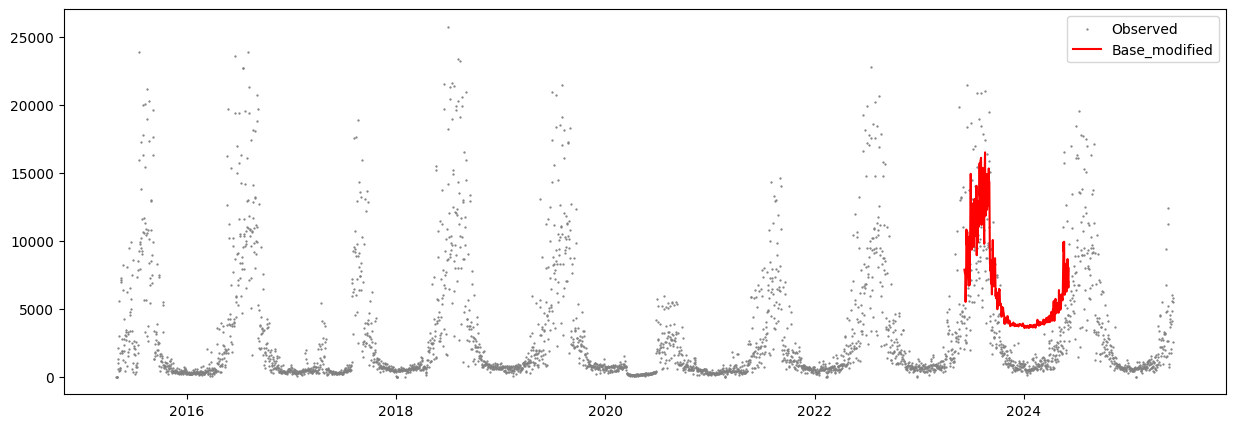

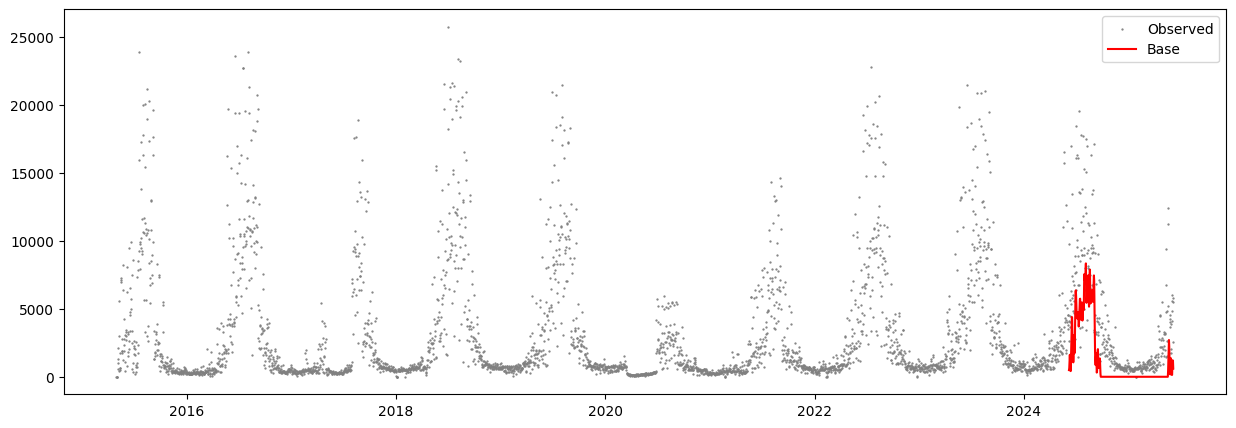

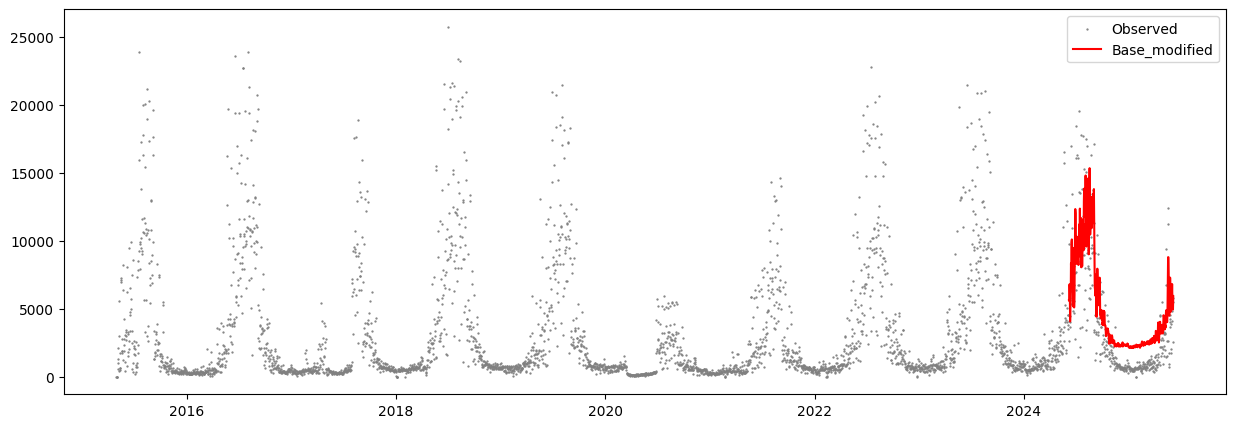

In [2]:
from Model_updated import RedemptionModel
import pandas as pd
import numpy as np 
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features 
    #df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    #df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

df = load_data('Toronto Island Ferry Ticket Counts.csv')


rm = RedemptionModel(df, 'Redemption Count')
rm.run_models()

In [ ]:
rm.results